<a href="https://colab.research.google.com/github/rajarathnambalakrishnan/Image-Recognition-for-Autonomous-Driving/blob/master/ResNet_34_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet 34 architecture
We use the ResNet 34 CNN architecture to perform the classification task for classification of vehicle class objects. 

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


TensorFlow 2.x selected.


In [0]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = "relu", **kwargs):
        
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters,3,strides = strides, padding = "SAME", use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding = "SAME", use_bias = False),
            keras.layers.BatchNormalization()]
        
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides, padding = "SAME", use_bias = False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        
        z = inputs
        
        for layer in self.main_layers:
            z = layer(z)
        
        skip_z = inputs
        
        for layer in self.skip_layers:
            skip_z = layer(skip_z)
        
        return self.activation(z + skip_z)
        

In [0]:
m = keras.models.Sequential()

m.add(keras.layers.Conv2D(64,7,strides = 2, input_shape = [224,224,3], padding = "SAME", use_bias = False))

m.add(keras.layers.BatchNormalization())

m.add(keras.layers.Activation("relu"))

m.add(keras.layers.MaxPool2D(pool_size = 3, strides =2, padding = "SAME"))

prev_filters = 64

for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    
    strides = 1 if filters == prev_filters else 2
    m.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters

m.add(keras.layers.GlobalAvgPool2D())
m.add(keras.layers.Flatten())
m.add(keras.layers.Dense(2,activation = "softmax"))

In [5]:
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

In [0]:
# we need to load the image data for training and validation from the disk 

In [8]:
os.getcwd()

'/content'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_dir = "/content/drive/My Drive/Google Colab Datasets/Pedestrian1/train inria"
validation_dir = "/content/drive/My Drive/Google Colab Datasets/Pedestrian1/test inria"

In [0]:
train_pos_dir = os.path.join(train_dir, 'pos')  # directory with our training pos pictures
train_neg_dir = os.path.join(train_dir, 'neg')  # directory with our training neg pictures
validation_pos_dir = os.path.join(validation_dir, 'pos')  # directory with our val pos pictures
validation_neg_dir = os.path.join(validation_dir, 'neg') # directory with our val neg pictures

In [0]:
num_pos_tr = len(os.listdir(train_pos_dir))
num_neg_tr = len(os.listdir(train_neg_dir))

num_pos_val = len(os.listdir(validation_pos_dir))
num_neg_val = len(os.listdir(validation_neg_dir))

total_train = num_pos_tr + num_neg_tr
total_val = num_pos_val + num_neg_val

In [11]:
print('total training positive images:', num_pos_tr)
print('total training negative images:', num_neg_tr)

print('total validation positive images:', num_pos_val)
print('total validation negative images:', num_neg_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training positive images: 614
total training negative images: 1218
total validation positive images: 288
total validation negative images: 453
--
Total training images: 1832
Total validation images: 741


In [0]:
# variables for preprocessing and training 

batch_size = 32
epochs = 15
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [14]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode="binary")

Found 1832 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 741 images belonging to 2 classes.


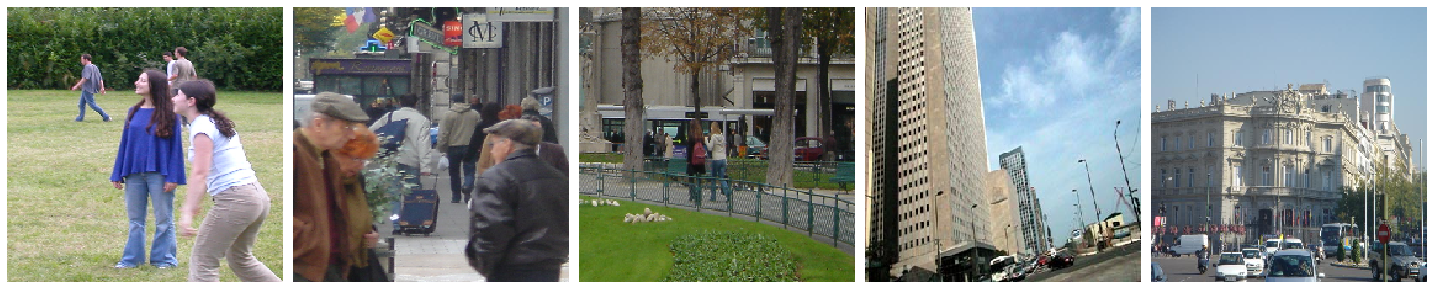

In [17]:
# let's visualize the training images

sample_training_images, _ = next(train_data_gen)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are 
# placed in each column.

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:5])

In [18]:
optimizer = keras.optimizers.SGD(lr = 0.1 , momentum = 0.9 , decay = 0.01) 

m.compile(loss = "sparse_categorical_crossentropy",optimizer=optimizer, metrics= ["accuracy"]) 

history = m.fit(train_data_gen, epochs = 5 , validation_data = val_data_gen) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 58 steps, validate for 24 steps
Epoch 1/5
58/58 [==============================] - 952s 16s/step - loss: 2.0369 - accuracy: 0.6130 - val_loss: 568375.4740 - val_accuracy: 0.6397
Epoch 2/5
58/58 [==============================] - 34s 588ms/step - loss: 0.6636 - accuracy: 0.6588 - val_loss: 2365.0151 - val_accuracy: 0.6208
Epoch 3/5
58/58 [==============================] - 34s 591ms/step - loss: 0.6813 - accuracy: 0.6512 - val_loss: 24.0615 - val_accuracy: 0.5560
Epoch 4/5
58/58 [==============================] - 34s 589ms/step - loss: 0.6352 - accuracy: 0.6665 - val_loss: 9.7775 - val_accuracy: 0.6356
Epoch 5/5
58/58 [==============================] - 34s 592ms/step - loss: 0.6120 - accuracy: 0.6670 - val_loss: 0.9493 - val_accuracy: 0.6059


In [0]:
# test set accuracy 

test_loss, test_acc = mo.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [0]:
predictions = model.predict(test_images)

In [0]:
# visulalize the predictions 
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()